In [1]:
%load_ext autoreload
%autoreload 2

In [17]:
import os
import pickle
import datetime
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = (10,9)

from scipy import stats
from ics.hxutils import hxramp
from phat import io, ramputils, statutils, plot
from phat import darks
import makefigures_noise

bestbaselines = open ('../data/paths/best_ever_baseline_darks_8_21_2022.txt', 'r').read().splitlines()[1:]

gain = 2.26 # e/ADU
cindices = np.logspace(1,np.log10(299),10).astype(int)

In [42]:
#dark_bundles = []
for dark_index in range(len(bestbaselines)):
    dr = darks.DarkRamp ( io.jhu2tiger(bestbaselines[dark_index]) )
    exptime = dr.header()['W_FRMTIM'] # s
    print(dark_index, exptime)
    bundle = dr.ols ( gain=gain, exptime=None, compute_indices=cindices, verbose=False)
    #bundle.interleaveOffset = dr.interleaveOffset
    delattr(bundle, 'offset_arr')
    delattr(bundle, 'offsetSE_arr')
    #dark_bundles.append(bundle)
    
    pickle_name = os.path.basename(io.jhu2tiger(bestbaselines[dark_index])).replace('.fits', '.pkl')
    with open(f'../data/output/{pickle_name}', 'wb') as outp:
        pickle.dump(bundle, outp, pickle.HIGHEST_PROTOCOL)
    del dr, bundle

0 10.85705
1 10.85705
2 10.85705
3 10.85705
4 10.85705
5 10.85705
6 10.85705
7 10.85705
8 5.61289
9 5.61289
10 5.61289
11 5.61289
12 5.61289
13 10.85705
14 10.85705
15 10.85705
16 10.85705
17 10.85705
18 10.85705


In [45]:
bundles = {}
for dark_index in [8,10]:
    pickle_name = os.path.basename(io.jhu2tiger(bestbaselines[dark_index])).replace('.fits', '.pkl')
    with open(f"../data/output/{pickle_name}", "rb") as input_file:
        bundles[dark_index] = pickle.load(input_file)

In [47]:
rmsAB = ramputils.rate_rms (bundles[8].rate_arr, bundles[10].rate_arr )
#rmsAA2 = ramputils.rate_rms (bundleA.rate_arr, bundleA2.rate_arr )

In [49]:
bundleA = bundles[8]
bundleB = bundles[10]


mod_arr = bundleA.rate_arr.copy()
for idx in range(bundleA.rate_arr.shape[0]):
    rdiff = bundleA.rate_arr[idx] - bundleB.rate_arr[idx]
    rdiff_mc,colmed_rdiff = ramputils.colsub ( rdiff, 1 )
    model = rdiff - rdiff_mc
    mod_arr[idx] -= model
rmsAB_modsub = ramputils.rate_rms ( mod_arr, bundleB.rate_arr )

In [54]:
shot_noise = np.sqrt(abs(np.median(bundleA.rate_arr, axis=(1,2))) * exptime * cindices)

se_c = np.median(bundleA.rateSE_arr,axis=(1,2))

pred = np.sqrt((se_c * exptime*cindices)**2 + shot_noise**2)
obs = rmsAB * exptime * cindices

obs/pred

In [1]:
fig, axarr = plt.subplots(1,2,figsize=(14,5))
fig.delaxes(axarr[1])
ax = axarr[0]
ax.plot(cindices, se_c * exptime * cindices, ls='--',lw=2, color='orange', label='OLS SE')
ax.plot(cindices, shot_noise, ls='--', lw=2, color='tab:green', label='est. shot noise')
ax.plot(cindices, np.sqrt((se_c * exptime*cindices)**2 + shot_noise**2), ls='--', lw=4, color='k',
        label='OLS SE + shot noise (in quad.)')


ax.plot(cindices, rmsAB * exptime * cindices, 'o-', markersize=8, color='tab:blue', label='Ramp - Ramp' )
ax.plot(cindices, rmsAB_modsub * exptime*cindices, 'o-', markersize=8, color='tab:red',
        label = 'Ramp - Ramp - model')
#ax.yscale('log')
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0., .1,1.))
ax.set_xscale('log')
ax.set_xlabel("number of reads")
ax.set_ylabel("RMS (e)")

plt.tight_layout ()


NameError: name 'plt' is not defined

Median rate: 0.0104 e/s
Expected shot noise: 5 e
Observed total RMS: 13 e
SQRT[RMS^2 - shot^2] = 12.65 e
column subtracted
Median rate: 0.0104 e/s
Expected shot noise: 5 e
Observed total RMS: 13 e
SQRT[RMS^2 - shot^2] = 12.48 e


(<Figure size 1008x360 with 4 Axes>, <Figure size 1512x360 with 6 Axes>)

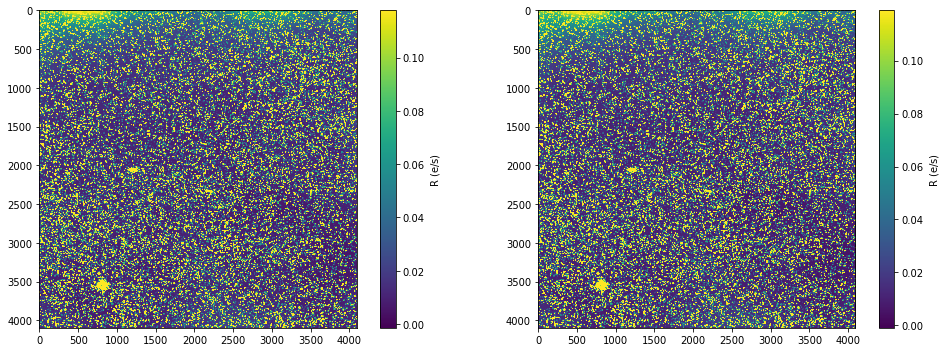

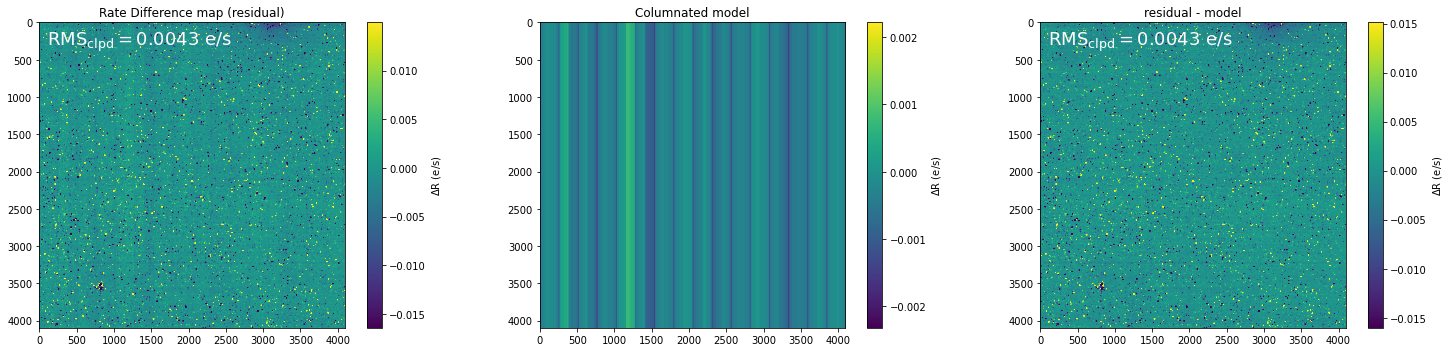

In [57]:
makefigures_noise.show_r2rdiff (bundleA.rate_arr[-1], bundleB.rate_arr[-1], exptime, cindices[-1] )